#Estudo sobre o emprego de Técnicas de **Machine Learning**
Este estudo, para tanto, implicará reunir de dados de natureza sócioeconômica com o fim de verificar a relação entre esses e a covid-19, no ambiente dos municípios brasileiros

##1. **Preparação** do Ambiente

In [1]:
### Montar o drive com os arquivos de dados

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Realizar atualizações e carregamento de libs

!pip install --upgrade scikit-learn
!pip install --upgrade pivottablejs

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Rich visual representation of estimators (new 0.23.2)
from sklearn import set_config
set_config(display='diagram')

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


     |████████████████████████████████| 6.8MB 4.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


##2. **Carregamento e Preparação** do dataset

In [3]:
### Carregar o dataset e exibir infos necessarias a sua análise e preparação
###

DIR_BASE = '/content/drive/MyDrive/Database/COVID19'

with zipfile.ZipFile(DIR_BASE+'/dataset_02.zip','r') as zip_ref:
  zip_ref.extractall(DIR_BASE+'/')

df_origin = pd.read_csv(DIR_BASE+'/dataset_02.csv', sep=';')
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4643 entries, 0 to 4642
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IBGE               4643 non-null   int64  
 1   PMATPUB_EF         4643 non-null   float64
 2   PMATPUB_EM         4643 non-null   float64
 3   DIST_EF_PUB        4643 non-null   float64
 4   DIST_EM_PUB        4643 non-null   float64
 5   IDEB_AI            4643 non-null   float64
 6   IDEB_AF            4643 non-null   float64
 7   DOCSUP_EF_PUB      4643 non-null   float64
 8   DOCSUP_EM_PUB      4643 non-null   float64
 9   TXMOINF            4643 non-null   float64
 10  TXBRUTAMORT        4643 non-null   float64
 11  TXCOBPLP           4643 non-null   float64
 12  PINTERSAP          4643 non-null   float64
 13  PINTERDRSAI        4643 non-null   float64
 14  REN_TRPCBF_D       4643 non-null   float64
 15  REN_TRPCBPC_D      4643 non-null   float64
 16  PDEFAGUA           4643 

In [20]:
### Alguns ajustes - remoção de variáveis que estão relacionadas ao estado, e não
###     ao município
###

df = df_origin.drop(columns=['IBGE', 'municipio', 'Capital', 'ESPVIDA', 'MORT1', 'T_ENV', 'RAZDEP', 'ANOSEST',
       'T_ANALF15M', 'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_FUND15A17',
       'R1040', 'RDPC', 'RDPC1', 'RDPC4', 'RMPOB', 'RPOB', 'PMPOB', 'PPOB', 'estado',
       'GINI', 'IDHM_E', 'IDHM_L', 'IDHM_R', 'IDHM', 'ANNUAL', 'RegMetro', 'estado', 'Porte'], errors=True)
df.drop_duplicates(inplace=True)
df = df.astype({ 
  'POP_TOT': float
})
df.columns

Index(['PMATPUB_EF', 'PMATPUB_EM', 'DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI',
       'IDEB_AF', 'DOCSUP_EF_PUB', 'DOCSUP_EM_PUB', 'TXMOINF', 'TXBRUTAMORT',
       'TXCOBPLP', 'PINTERSAP', 'PINTERDRSAI', 'REN_TRPCBF_D', 'REN_TRPCBPC_D',
       'PDEFAGUA', 'PDEFESGOTO', 'PDEFLIXO', 'PDEFSAN', 'PPOB_POS', 'PBF',
       'SNIS_PAGUA', 'PFOCOS', 'POP_TOT', 'casosAcumulado', 'obitosAcumulado',
       'Região', 'LON', 'LAT'],
      dtype='object')

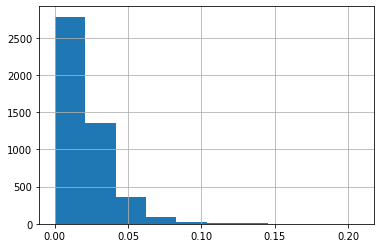

In [21]:
### Criando a variável que demonstra o grau de incidência
###     PCA_TP: porcentagem (casos acumulados dividido por total da população
###     município a município)
###
### Observação: são considerados os casos acumulados até à data de 01 de
###     Novembro de 2020
###

if ('incidencia' in df.columns): 
  df.drop(columns=['incidencia'], inplace=True)
df = df.assign(incidencia="")

df.loc[:, 'incidencia'] = (df['casosAcumulado']/df['POP_TOT'])
df['incidencia'].hist()

In [22]:
### Para criar as classes da variávei alvo a partir da incidência demonstrada
###    na célula anterior
###

df['incidencia'].describe()

count    4643.000000
mean        0.021440
std         0.017617
min         0.000106
25%         0.009433
50%         0.017067
75%         0.028174
max         0.207346
Name: incidencia, dtype: float64

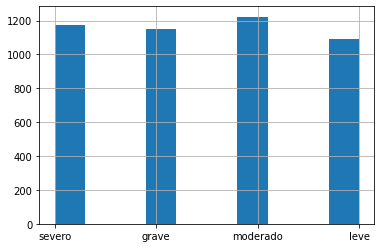

In [23]:
### Categorizar o 'Y' (variável alvo) (incidência), com base os quartiles vistos na célula
###     anterior
###

if ('Y' in df.columns): 
  df.drop(columns=['Y'], inplace=True)
df = df.assign(Y="")

df.loc[df['incidencia'] <= 0.009, ('Y')] = 'leve'
df.loc[(df['incidencia'] > 0.009) & (df['incidencia'] <= 0.017), ('Y')] = 'moderado'
df.loc[(df['incidencia'] > 0.017) & (df['incidencia'] <= 0.028), ('Y')] = 'grave'
df.loc[df['incidencia'] > 0.028, ('Y')] = 'severo'

df['Y'].hist()

In [24]:
### ^
### Como é visto, as classes estão relativamente balanceadas, uma vez que
### correspondem aos quartiles

# Célula seria usada para realizar balanceameto

In [25]:
### Remoção de variáveis que auxiliam a definição do Y
### 

df.drop(columns=['casosAcumulado', 'obitosAcumulado', 'POP_TOT'], inplace=True)

In [26]:
### Definição das classes para extração de novas features e melhorias na 
###     categorização dos dados no dataset, além na normalização dos dados
###     numéricos

#=========================================================
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

#=========================================================
# Handling categorical features 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes one boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 

  def get_feature_names(self):
        return self.colnames.tolist()

  # Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # customize feature?
    # how can I identify this one? EDA!!!!
    # if self.new_features: 

      # Desnecessário, atividade realizada em notebook anterior

    # update column names
    self.colnames = df.columns      
  
    return df

#=========================================================
# transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes a model parameter as its argument
  # model 0: minmax
  # model 1: standard
  # model 2: without scaler
  def __init__(self, model = 0):
    self.model = model
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self

  # return columns names after transformation
  def get_feature_names(self):
        return self.colnames 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # update columns name
    self.colnames = df.columns.tolist()
    
    # minmax
    if self.model == 0: 
      scaler = MinMaxScaler()
      # transform data
      df = scaler.fit_transform(df)
    elif self.model == 1:
      scaler = StandardScaler()
      # transform data
      df = scaler.fit_transform(df)
    else:
      df = df.values

    return df


In [27]:
### Remoção de Outliners

# Verify if columns[float64] has outliers (with data leakage!!!!!!!)
x = df.select_dtypes("float64")

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("df shape [original]: {}".format(df.shape))
print("df shape [outlier removal]: {}".format(df.loc[mask,:].shape))

# municipios with outliner
df_w = df.loc[mask,:].copy()
df_w.head()

df shape [original]: (4643, 28)
df shape [outlier removal]: (4622, 28)


,PMATPUB_EF,PMATPUB_EM,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,DOCSUP_EM_PUB,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERSAP,PINTERDRSAI,REN_TRPCBF_D,REN_TRPCBPC_D,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,PPOB_POS,PBF,SNIS_PAGUA,PFOCOS,Região,LON,LAT,incidencia,Y
0,100.00,100.00,19.9,25.1,6.2,4.8,58.1,61.7,14.12,5.39,6.01,41.53,4.64,79.30,142.56,80.81,93.09,53.62,50.15,84.71,66.31,73.27,0.52,Região Norte,-61.9958,-11.9287,0.035499,severo
1,89.42,95.84,20.2,31.4,5.5,4.9,63.4,64.8,13.34,4.68,7.06,25.15,2.23,41.87,178.73,64.66,89.42,14.74,13.47,79.91,57.66,94.81,0.78,Região Norte,-63.0330,-9.9061,0.054404,severo
2,100.00,100.00,11.8,27.8,6.1,5.1,73.5,60.7,0.00,4.66,3.31,47.04,7.47,36.76,103.04,64.37,40.09,40.23,17.92,75.32,47.87,85.80,0.06,Região Norte,-60.5446,-13.4951,0.022012,grave
3,82.46,80.47,14.0,28.8,6.3,5.1,60.8,54.2,9.64,5.66,9.07,23.99,2.05,29.62,156.91,26.36,56.03,22.47,20.70,76.88,47.86,100.00,0.18,Região Norte,-61.4566,-11.4347,0.028631,severo
4,96.31,97.47,15.5,26.9,6.4,5.3,65.8,39.2,3.61,4.52,3.81,37.16,6.46,44.39,172.70,68.13,91.35,11.01,10.22,68.43,46.38,64.95,0.49,Região Norte,-60.8173,-13.1874,0.015390,moderado


In [28]:
df_w.columns

Index(['PMATPUB_EF', 'PMATPUB_EM', 'DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI',
       'IDEB_AF', 'DOCSUP_EF_PUB', 'DOCSUP_EM_PUB', 'TXMOINF', 'TXBRUTAMORT',
       'TXCOBPLP', 'PINTERSAP', 'PINTERDRSAI', 'REN_TRPCBF_D', 'REN_TRPCBPC_D',
       'PDEFAGUA', 'PDEFESGOTO', 'PDEFLIXO', 'PDEFSAN', 'PPOB_POS', 'PBF',
       'SNIS_PAGUA', 'PFOCOS', 'Região', 'LON', 'LAT', 'incidencia', 'Y'],
      dtype='object')

#3. Preparando os **Classificadores** (via pipeline)

In [29]:
### split-out train/validation and test dataset

X_train, X_test, y_train, y_test = train_test_split(df_w.drop(labels="Y",axis=1),
                                                    df_w["Y"],
                                                    test_size=0.20,
                                                    random_state=41,
                                                    shuffle=True,
                                                    stratify=df_w["Y"])

In [30]:
X_train.columns

Index(['PMATPUB_EF', 'PMATPUB_EM', 'DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI',
       'IDEB_AF', 'DOCSUP_EF_PUB', 'DOCSUP_EM_PUB', 'TXMOINF', 'TXBRUTAMORT',
       'TXCOBPLP', 'PINTERSAP', 'PINTERDRSAI', 'REN_TRPCBF_D', 'REN_TRPCBPC_D',
       'PDEFAGUA', 'PDEFESGOTO', 'PDEFLIXO', 'PDEFSAN', 'PPOB_POS', 'PBF',
       'SNIS_PAGUA', 'PFOCOS', 'Região', 'LON', 'LAT', 'incidencia'],
      dtype='object')

In [31]:
### Preparação do Pipeline

# Categrical features to pass down the categorical pipeline 
categorical_features = X_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = X_train.select_dtypes("float64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer()),
                                         ('cat_encoder','passthrough')
                                         #('cat_encoder',OneHotEncoder(sparse=False,drop="first"))
                                         ]
                                )

# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('num_transformer', NumericalTransformer()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('cat_pipeline', categorical_pipeline),
                                                               ('num_pipeline', numerical_pipeline)
                                                               ]
                                           )

In [32]:
### Configuração e execução do Pipeline

seed = 15
num_folds = 10
# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
scoring = {'Accuracy': make_scorer(accuracy_score)}

# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs", SelectKBest()),
                         ("classifier", DecisionTreeClassifier())])

# create a dictionary with the hyperparameters
search_space = [
                {"classifier": [DecisionTreeClassifier()],
                 "classifier__criterion": ["gini", "entropy"],
                 "classifier__splitter": ["best", "random"],
                 "fs__k": [11, 13, 17, 19, 23],
                 "fs__score_func": [mutual_info_classif],  #[f_classif, mutual_info_classif, chi2],
                 "full_pipeline__cat_pipeline__cat_encoder": [OneHotEncoder(sparse=False,drop="first")], #[OneHotEncoder(sparse=False,drop="first"), OrdinalEncoder()],
                 "full_pipeline__cat_pipeline__cat_transformer__new_features": [False],
                 "full_pipeline__num_pipeline__num_transformer__model": [1,0]},
                 {"classifier": [RandomForestClassifier()],
                 "classifier__criterion": ["gini","entropy"], 
                 "classifier__n_estimators": [100, 200, 300, 500],
                 "fs__k":[11, 13, 17, 19, 23],
                 "fs__score_func": [mutual_info_classif],
                 "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]},
                # {"classifier": [AdaBoostingClassifier()],
                #  "classifier__n_estimators": np.random.randint(100,500,size=100), 
                #  "classifier__learning_rate": [ 0.01, 0.1, 0.2 ],
                #  "classifier__random_state": [seed],
                #  "fs__k": [10, 12, 15, 17, 20],
                #  "fs__score_func": [mutual_info_classif],
                #  "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]},
                # {"classifier": [GradientBoostingClassifier()],
                #  "classifier__n_estimators": np.random.randint(100,500,size=100), 
                #  "classifier__learning_rate": [ 0.01, 0.1, 0.2 ],
                #  "classifier__random_state": [seed],
                #  "fs__k": [10, 12, 15, 17, 20],
                #  "fs__score_func": [mutual_info_classif],
                #  "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]}
                ]

# create grid search
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True),
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy",
                    verbose = 1)

### fit grid search
all_models = grid.fit(X_train, y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 24.6min finished


In [ ]:
all_models

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('full_pipeline',
                                        FeatureUnion(transformer_list=[('cat_pipeline',
                                                                        Pipeline(steps=[('cat_selector',
                                                                                         FeatureSelector(feature_names=['estado',
                                                                                                                        'RegMetro',
                                                                                                                        'Região',
                                                                                                                        'Porte'])),
                                                                                        ('cat_transformer',
                                                                                         CategoricalTransformer()),
                                                                                        ('cat_encoder',
                                                                                         'passthrough')])),
                                                                       ('num...
                          'fs__score_func': [<function mutual_info_classif at 0x7f6cf6e6a268>],
                          'full_pipeline__cat_pipeline__cat_encoder': [OneHotEncoder(drop='first',
                                                                                     sparse=False)],
                          'full_pipeline__cat_pipeline__cat_transformer__new_features': [False],
                          'full_pipeline__num_pipeline__num_transformer__model': [1]}],
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=1)

In [39]:
## Verificando o melhor resultado para o modelo

print("Melhor resultado: %f usando %s" % (all_models.best_score_,all_models.best_params_))

Melhor resultado: 0.972666 usando {'classifier': DecisionTreeClassifier(), 'classifier__criterion': 'gini', 'classifier__splitter': 'best', 'fs__k': 11, 'fs__score_func': <function mutual_info_classif at 0x7f3fdcd53268>, 'full_pipeline__cat_pipeline__cat_encoder': OneHotEncoder(drop='first', sparse=False), 'full_pipeline__cat_pipeline__cat_transformer__new_features': False, 'full_pipeline__num_pipeline__num_transformer__model': 1}


In [41]:
## Realizando a predição com o X de teste

predict = all_models.predict(X_test)

In [43]:
## Avaliando/Comparando o resultado com o Y de teste

print(accuracy_score(y_test, predict))

0.9589189189189189


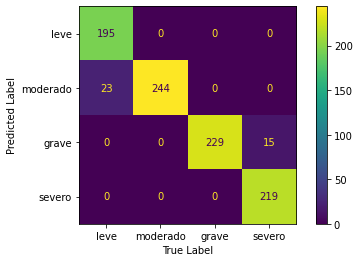

In [36]:
## Desenhando a matriz de confusão em um gráfico

fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=["leve","moderado","grave","severo"]),
                       display_labels=["leve","moderado","grave","severo"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [37]:
### ^
### O que se nota acima é apenas uma confusão entre leves e moderados. 
###    Certamete o modelo precise ser melhor caraterizado em termos de suas
###    categorias

['PMATPUB_EM', 'DIST_EM_PUB', 'PINTERDRSAI', 'REN_TRPCBF_D', 'PDEFAGUA', 'PBF', 'SNIS_PAGUA', 'incidencia']


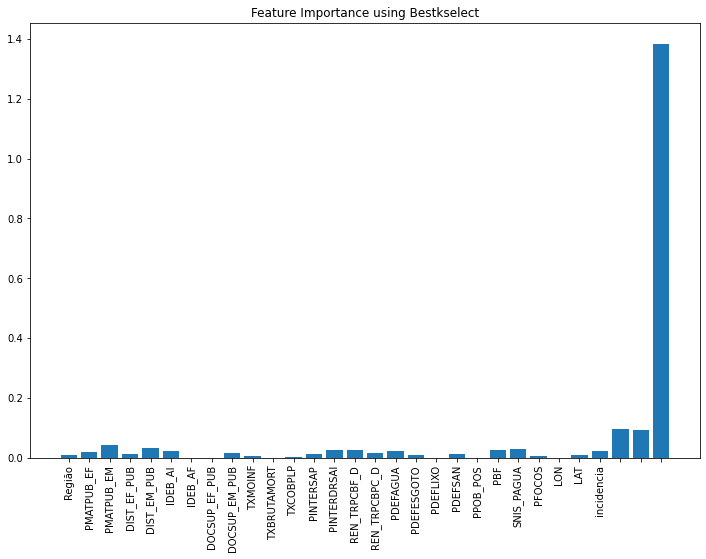

DecisionTreeClassifier()


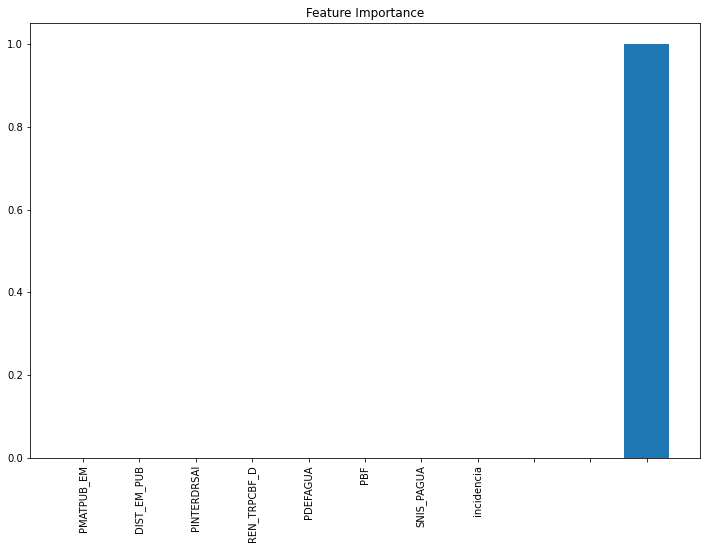

In [38]:
## Investigando de que forma as variáveis contribuíram para o resultado

# columns used in the model (k columns)
features = all_models.best_estimator_.named_steps['fs']

# All information is trackable going back in the Pipeline
# categorical columns
features_full = all_models.best_estimator_.named_steps['full_pipeline']
features_cat = features_full.get_params()["cat_pipeline"]

# numerical columns
features_full.get_params()["num_pipeline"][1].get_feature_names()

# all columns (cat + num)
all_columns = features_cat[1].get_feature_names() + features_full.get_params()["num_pipeline"][1].get_feature_names()


selected_columns = [value for (value, filter) in zip(all_columns, features.get_support()) if filter]
print(selected_columns)

fig, ax = plt.subplots(1,1,figsize=(12,8))
xticks = [x for x in range(len(features.scores_))] 
ax.bar(xticks, features.scores_)
ax.set_xticks(xticks)
ax.set_xticklabels(all_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance using Bestkselect")
plt.show()

classifier = all_models.best_estimator_.named_steps['classifier']
print(classifier)

# classifier.feature_importances_.shape
fig, ax = plt.subplots(1,1,figsize=(12,8))

xticks = [x for x in range(len(classifier.feature_importances_))] 
ax.bar(xticks, classifier.feature_importances_)
ax.set_xticks(xticks)
ax.set_xticklabels(selected_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance")
plt.show()